In [1]:
import numpy as np
import gensim
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
import re
import statsmodels.formula.api
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib nbagg

## Protected Groups

Race,
Color,
Religion or creed,
National origin or ancestry,
Sex,
Age,
Physical or mental disability,
Veteran status,
Genetic information,
Citizenship

In [2]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 
              'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 
              'female', 'nonbinary', 'african', 'african american', 'black', 'white', 
              'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 
              'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 
              'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 
              'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 
              'elderly', 'blind', 'deaf', 'paralyzed']

In [3]:
nationalities=[
'German',
#'African_American',
'Mexican',
'Irish',
'English',
'American',
'Italian',
'Polish',
'French',
'Scottish',
#'Puerto_Rican',
'Norwegian',
'Dutch',
'Swedish',
'Chinese',
'Indian',
'Russian',
'Filipino'
]

In [4]:
religions =[ 
    'Zionist',
    'Catholic',
    'Christian',
    'Islamic',
    'Protestant',
    'Taoist',
    'Atheist',
    'Hindu',
    'Buddhist',
    'Diasporic',
    'Sikh',
    'Juche',
    'Jewish',
    'Bahai',
    'Jains',
    'Shinto',
    'Pagan'
]

In [5]:
gender= ["male","female","her","him","man","woman","boy","girl","his","hers","mom","dad"]#perhaps try all terms intraprotected group

## Utility methods

In [6]:
def text_to_vector(embeddings,text):
    tokens = text.split()
    words = filter(lambda x: x in embeddings,[x.lower() for x in words])
    if len(words)>0:
        return np.mean(embeddings[words],axis = 0)
    return None

In [7]:
def words_to_toxicity(model,embeddings,words):
    words = list(filter(lambda x: x in embeddings,[x.lower() for x in words]))
    if len(words)>0:
        vector = np.mean(embeddings[words],axis = 0)
        prob = model.predict_prob(vector)
        return prob
    else: return 0;

In [8]:
def text_to_toxicity(model,embeddings,text):
    tokens = text.split()
    toxicity = words_to_toxicity(model,embeddings,tokens)
    return toxicity

In [9]:
def identity_toxicity_table(identities,embeddings,model,add=None):
    words = []
    toxicities = []
    for word in sorted(identities):
        word = add + word if add else word
        word = word.lower()
        toxicities.append(text_to_toxicity(model, embeddings,word.lower()))
        words.append(word)
    return zip(words,toxicities)

In [10]:
def load_lexicon(filename):
    lexicon = []
    with open(filename) as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [11]:
def generate_train_test_set(model,targets,sentences,dim=300):
    vectors = np.zeros((len(sentences),dim))
    labels = np.zeros((len(sentences)))
    count=0
    for i,sentence in enumerate(sentences):
        words = filter(lambda x: x in model,[x.lower() for x in sentence.split()])
        if len(words)>0:
            vectors[count,:] = np.mean(model[words],axis = 0)
            labels[count] = targets[i] 
            count+=1
    print(count, " sentences in embeddings, ", len(sentences) - count, " sentences not in embeddings")
    return train_test_split(vectors, labels, test_size=0.1, random_state=0)

In [12]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=5000,val=None,X_tils =[],lamb=.1,reg_coeff=[]):
        self.lr = lr
        self.num_iter = num_iter
        self.val = val
        self.X_tils = X_tils
        self.lamb = lamb
        self.reg_coeff = reg_coeff
   
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def calculate_fairness_reg_grad(self,theta):
        fair_reg_sum = 0
        for i,X_til in enumerate(self.X_tils):
            l = np.shape(X_til)[0]
            z_til = np.dot(X_til, theta)
            h_til = self.__sigmoid(z_til)
            T = np.sum(h_til)
            fair_reg_sum+=self.reg_coeff[i]*(np.sum(X_til.T*h_til*(1-h_til)*(np.log(l*h_til)+1),axis=1))
        return fair_reg_sum
    
    def fit(self, X, y):
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        RNSB = []
        loss = []
        validation_scores = []
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            r = self.calculate_fairness_reg_grad(self.theta)
            grad_loss = np.dot(X.T, (h - y)) / y.size
            #logistic loss + L2 regularization + sum(fair_reg)
            if(i % 1000 == 0):
                print(np.sum(np.abs(grad_loss)), np.sum(np.abs(2*self.lamb*self.theta)), np.sum(np.abs(r)))
            gradient = grad_loss + 2*self.lamb*self.theta+ r
            self.theta -= self.lr * gradient
            RNSB.append(self.validation_fairness())
            loss.append(self.__loss(h, y))
            validation_scores.append(self.validation(self.val[0],self.val[1]))
            if(i % 1000 == 0):
                z = np.dot(X, self.theta)
                h = self.__sigmoid(z)
                print('loss: ' ,self.__loss(h, y))
                if self.val:
                    print('validation MAp: ', self.validation(self.val[0],self.val[1]))
                if len(self.X_tils)>0:
                    print('RNSB: ', self.validation_fairness())
        return (RNSB,loss,validation_scores)    
    
    def predict_prob(self, X):
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict_proba(self, X):
        return [1-self.__sigmoid(np.dot(X, self.theta)),self.__sigmoid(np.dot(X, self.theta))]
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold
    
    def validation(self,X,Y):
        return np.mean(self.predict(X,.5)==Y)
    
    def validation_fairness(self):
        vals = []
        for Xtil in self.X_tils:
            probs = self.predict_prob(Xtil)
            probs = probs/np.sum(probs)
            uniform = np.ones(len(probs))*1./len(probs)
            vals.append((probs * np.log(probs/uniform)).sum())
        return vals
    def print_val_fairness(self):
        vals = []
        for Xtil in self.X_tils:
            probs = self.predict_prob(Xtil)
            probs = probs/np.sum(probs)
            print(probs)
            uniform = np.ones(len(probs))*1./len(probs)
            vals.append((probs * np.log(probs/uniform)).sum())
        print(vals)

## Load Datasets

In [ ]:
!pip3 install glove

In [13]:
#GLOVE
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'data/glove.6B/glove.6B.300d.txt'
word2vec_output_file = 'data/glove.6B/glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)

#Word2vec
# embeddings = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)

#universal sentence encoder
# import tensorflow as tf
# import tensorflow_hub as hub
# module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
# # Import the Universal Sentence Encoder's TF Hub module
# embed = hub.Module(module_url)

In [14]:
#kaggle

#df = pd.read_csv("data/kaggle_toxicity/train.csv")

#word sentiment

pos_words = load_lexicon("data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("data/opinion_lexicon/negative-words.txt")

#imbd

# import numpy
# from keras.datasets import imdb
# from matplotlib import pyplot
# # load the dataset
# (X_train, y_train), (X_test, y_test) = imdb.load_data()
# X = numpy.concatenate((X_train, X_test), axis=0)
# y = numpy.concatenate((y_train, y_test), axis=0)

## Initialize word sentiment dataset or toxicity dataset (wiki)

In [ ]:
np.shape(train_vectors)

In [15]:
#sentiment word dataset from positve/negative reviews
#'''
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([0 for entry in pos_vectors] + [1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
#'''
#toxicity tweet dataset
#''''''
# toxic_sentences = df[df["toxic"]==1]["comment_text"]
# num_toxic_samples = len(toxic_sentences)
# non_toxic_sentences = df[df["toxic"]==0]["comment_text"].sample(num_toxic_samples)
# sentences = pd.concat([toxic_sentences, non_toxic_sentences])
# targets  = np.zeros(num_toxic_samples*2)
# targets[0:num_toxic_samples] = 1
# train_vectors, test_vectors, train_targets, test_targets = generate_train_test_set(embeddings,targets,sentences)
# sentences = map(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x.lower()),list(sentences))
# # message_embeddings = None
# # with tf.Session() as session:
# #     session.run([tf.global_variables_initializer(), tf.tables_initializer()])
# #     message_embeddings = session.run(embed(sentences))
# #     print np.shape(message_embeddings)
# from sklearn.feature_extraction.text import TfidfVectorizer
# vec = TfidfVectorizer(ngram_range=(1,2),
#                min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
#                smooth_idf=1, sublinear_tf=1)
# trn_term_doc = vec.fit_transform(sentences)

# train_vectors, test_vectors, train_targets, test_targets = train_test_split(trn_term_doc.todense(), targets,test_size=0.1, random_state=0)

#'''


    
# import re, string
# re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
# def tokenize(s): return re_tok.sub(r' \1 ', s).split()
# n = train.shape[0]
# vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
#                min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
#                smooth_idf=1, sublinear_tf=1 )
# trn_term_doc = vec.fit_transform(train[COMMENT])
# test_term_doc = vec.transform(test[COMMENT])
#imbd movie ratings?????

## PCA

In [16]:
def remove_component(matrix, row_index):
    return np.delete(matrix,row_index,1)

# Deprecated. Or at least not used right now.
def remove_principle_component(X_matrix, component_index):
    u, s, vt = np.linalg.svd(X_matrix, full_matrices=False)
    u_new = np.delete(u, component_index, 1)    
    s_new = np.delete(s, component_index) 
    vt_new = np.delete(vt, component_index, 0)
    return np.mat(u_new)* np.diag(s_new) * np.mat(vt_new)

# Deprecated. Or at least not used right now.
def leave_one_out(X_matrix):
    print("leaving one out...")
    list_of_Xs = []
    for i in range(X_matrix.shape[1]):
        X_without_i = remove_principle_component(X_matrix, i)
        list_of_Xs.append(np.array(X_without_i))
    return list_of_Xs

def leave_one_out_efficiently(X_matrix, num_top_components_to_remove=float('inf')):
    list_of_Xs = []
    u, s, vt = np.linalg.svd(X_matrix, full_matrices=False)
    
    for i in range(min(X_matrix.shape[1], num_top_components_to_remove)):
        u_new = np.delete(u, i, 1)    
        s_new = np.delete(s, i) 
        vt_new = np.delete(vt, i, 0)
        X_without_i = np.mat(u_new)* np.diag(s_new) * np.mat(vt_new)
        list_of_Xs.append(np.array(X_without_i))
    return list_of_Xs

In [17]:
def run_lr_on_this_data(new_train_vectors):    
    lr = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers,reg_coeff=[0,0,0],lamb=0.01,num_iter=8000)
    (RNSB,loss,validation_scores) = lr.fit(new_train_vectors,train_targets)
    return lr
    print("----------------------------------------------")

In [ ]:
def run_loo_experiment(num_singular_vectors):
    leave_one_out_matricies = leave_one_out_efficiently(train_vectors, num_singular_vectors)

#     Un-pca'd LR
    og_lr = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers,reg_coeff=[0,0,0],lamb=0.01,num_iter=4000)
    (RNSB,loss,validation_scores) = og_lr.fit(train_vectors,train_targets)

    lr_metrics = []
    
    for i in range(len(leave_one_out_matricies)):
        lr_metrics.append(run_lr_on_this_data(leave_one_out_matricies[i]))
        print("finished with " + str(i) + " runs of " + str(len(leave_one_out_matricies)))
        print("____________________")
        print()
        
    return lr_metrics#, og_lr 


In [18]:
# Need here for regularizers, even if all are zero.
N = np.zeros((len(nationalities),300))
for i,j in enumerate(nationalities):
    N[i,:] = embeddings[j.lower()]
R = np.zeros((len(religions),300))
for i,j in enumerate(religions):
    R[i,:] = embeddings[j.lower()]
G = np.zeros((len(gender),300))
for i,j in enumerate(gender):
    G[i,:] = embeddings[j.lower()]
regularizers = [N,R,G]

In [ ]:
# lr_metrics, og_lr = run_loo_experiment(20)
    
lr_metrics = run_loo_experiment(5)

In [19]:
og_lr = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers,reg_coeff=[0,0,0],lamb=0.01,num_iter=4000)
(RNSB,loss,validation_scores) = og_lr.fit(train_vectors,train_targets)

6.67731607316 0.0 0.0
loss:  0.690806938888
validation MAp:  0.774038461538
RNSB:  [1.2337028740690939e-07, 2.1538976197832401e-06, 3.7378536644028877e-07]
1.48099565479 0.447926492306 0.0
loss:  0.314153624448
validation MAp:  0.900641025641
RNSB:  [0.042099657028117535, 0.070295260016458527, 0.024795884737000493]
1.0262187447 0.580921375259 0.0
loss:  0.270939466524
validation MAp:  0.911858974359
RNSB:  [0.070477078261294041, 0.096361227460164553, 0.040996409070636078]
0.869473784181 0.64328313835 0.0
loss:  0.255417367627
validation MAp:  0.908653846154
RNSB:  [0.084833309095563539, 0.10962604330265141, 0.049544524539065243]


In [20]:
og_lr.validation(og_lr.val[0],og_lr.val[1])

0.91025641025641024

## Plotting PCA

In [ ]:
def plot_RNSB_bar(lr_list, og_lr):
    
    rnsb_list = [i.validation_fairness() for i in lr_list]
    metric_a, metric_b, metric_c  = zip(*rnsb_list)
    
#     identity_toxicity = dict(identity_toxicity_table(nationalities,embeddings,lr))
#     identity_toxicity = list(zip(*identity_toxicity.items()))
    
    %matplotlib inline
    plt.figure(figsize=(6,4))
    plt.title("National Origin",fontsize=20)
    index = np.arange(len(metric_a)) + 1
    plt.bar(index,metric_a)
    plt.xticks(index, index, fontsize=15, rotation=45)
    plt.axes().axhline(y=og_lr.validation_fairness()[0], color="gray")
    plt.ylabel("RNSB",fontsize=16)
    plt.xlabel("nth-largest singular vector removed",fontsize=16)
    plt.show()
    
    %matplotlib inline
    plt.figure(figsize=(6,4))
    plt.title("Religion",fontsize=20)
    index = np.arange(len(metric_b)) + 1
    plt.bar(index,metric_b)
    plt.xticks(index, index, fontsize=15, rotation=45)
    plt.axes().axhline(y=og_lr.validation_fairness()[1], color="gray")
    plt.ylabel("RNSB",fontsize=16)
    plt.xlabel("nth-largest singular vector removed",fontsize=16)
    plt.show()
    
    
    %matplotlib inline
    plt.figure(figsize=(6,4))
    plt.title("Gender",fontsize=20)
    index = np.arange(len(metric_c)) + 1
    plt.bar(index,metric_c)
    plt.xticks(index, index, fontsize=15, rotation=45)
    plt.axes().axhline(y=og_lr.validation_fairness()[2], color="gray")
    plt.ylabel("RNSB",fontsize=16)
    plt.xlabel("nth-largest singular vector removed",fontsize=16)
    plt.show()

    
print(og_lr.validation_fairness())
for lr in lr_metrics:
    print(lr.validation(lr.val[0],lr.val[1]))
plot_RNSB_bar(lr_metrics, og_lr)



In [ ]:
def annotate_data(labels, points, plt):
    
    for label, point in zip(labels, points):
        plt.annotate(label,xy=point,fontsize=15)
    

def plot_RNSB_scatter(lr_list, og_lr):
    
    rnsb_list = [lr.validation_fairness() for lr in lr_list]
    validation_list = [lr.validation(lr.val[0],lr.val[1]) for lr in lr_list]
    metric_a, metric_b, metric_c  = zip(*rnsb_list)
    
    og_rnsb_a, og_rnsb_b, og_rnsb_c = og_lr.validation_fairness()
    og_validation = og_lr.validation(og_lr.val[0],og_lr.val[1])
    
    %matplotlib inline
    plt.figure(figsize=(6,4))
    plt.title("National Origin",fontsize=20)
    plt.xlabel("Validation Accuracy")
    plt.ylabel("RNSB")
    plt.scatter(validation_list, metric_a)
    plt.scatter(og_validation, og_rnsb_a, color="red")
    plt.axes().axhline(y=og_rnsb_a, color="gray")
    plt.axes().axvline(x=og_validation, color="gray")
    annotate_data([str(i+1) for i in range(len(lr_list))], zip(validation_list, metric_a), plt)
    plt.show()
    
    %matplotlib inline
    plt.figure(figsize=(6,4))
    plt.title("Religion",fontsize=20)
    plt.xlabel("Validation Accuracy")
    plt.ylabel("RNSB")
    plt.scatter(validation_list, metric_b)
    plt.scatter(og_validation, og_rnsb_b, color="red")
    plt.axes().axhline(y=og_rnsb_b, color="gray")
    plt.axes().axvline(x=og_validation, color="gray")
    annotate_data([str(i+1) for i in range(len(lr_list))], zip(validation_list, metric_b), plt)
    plt.show()
    
    %matplotlib inline
    plt.figure(figsize=(6,4))
    plt.title("Gender",fontsize=20)
    plt.xlabel("Validation Accuracy")
    plt.ylabel("RNSB")
    plt.scatter(validation_list, metric_c)
    plt.scatter(og_validation, og_rnsb_c, color="red")
    plt.axes().axhline(y=og_rnsb_c, color="gray")
    plt.axes().axvline(x=og_validation, color="gray")
    annotate_data([str(i+1) for i in range(len(lr_list))], zip(validation_list, metric_c), plt)
    plt.show()
    
    
plot_RNSB_scatter(lr_metrics, og_lr)


## Plot RNSB vs Accuracy for Reg and PCA

In [ ]:
lr_debias

In [21]:
# Original, non-fairness whatever lr
og_lr = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers,reg_coeff=[0,0,0],lamb=0.01,num_iter=4000)
(RNSB_debias,loss_debias,validation_scores_debias) = og_lr.fit(train_vectors,train_targets)

# Regularized
lr_debias = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers,reg_coeff=[.2,.2,.2],lamb=0.01,num_iter=4000)
(RNSB_debias,loss_debias,validation_scores_debias) = lr_debias.fit(train_vectors,train_targets)


6.67731607316 0.0 0.0
loss:  0.690806938888
validation MAp:  0.774038461538
RNSB:  [1.2337028740690939e-07, 2.1538976197832401e-06, 3.7378536644028877e-07]
1.48099565479 0.447926492306 0.0
loss:  0.314153624448
validation MAp:  0.900641025641
RNSB:  [0.042099657028117535, 0.070295260016458527, 0.024795884737000493]
1.0262187447 0.580921375259 0.0
loss:  0.270939466524
validation MAp:  0.911858974359
RNSB:  [0.070477078261294041, 0.096361227460164553, 0.040996409070636078]
0.869473784181 0.64328313835 0.0
loss:  0.255417367627
validation MAp:  0.908653846154
RNSB:  [0.084833309095563539, 0.10962604330265141, 0.049544524539065243]
6.67731607316 0.0 260.230511771
loss:  0.680765173817
validation MAp:  0.559294871795
RNSB:  [0.001136268238864693, 0.019059643529175774, 0.0069855950655610972]
2.06924401028 0.635108924153 1.64959396997
loss:  0.3607926851
validation MAp:  0.841346153846
RNSB:  [0.049511161519375221, 0.2007048659848033, 0.064820225578583565]
1.56804604778 0.748051720244 1.3886

In [22]:
train_vectors_5 = np.array(remove_principle_component(train_vectors,4))

# Removing 5th principle component
lr_minus5 = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers,reg_coeff=[0,0,0],lamb=0.01,num_iter=4000)
(RNSB_debias,loss_debias,validation_scores_debias) = lr_minus5.fit(train_vectors_5, train_targets)


6.56384235671 0.0 0.0
loss:  0.690856537904
validation MAp:  0.777243589744
RNSB:  [9.4537982424941643e-08, 1.8962333443739011e-06, 3.2259507139171346e-07]
1.48859468565 0.443235353959 0.0
loss:  0.32675841767
validation MAp:  0.900641025641
RNSB:  [0.027611201890838225, 0.039258764326004114, 0.020620928552867519]
1.03215893087 0.579222693007 0.0
loss:  0.284219368225
validation MAp:  0.918269230769
RNSB:  [0.045636703431975165, 0.049776733846981808, 0.033045967005450469]
0.872457725375 0.643380592881 0.0
loss:  0.268799733933
validation MAp:  0.919871794872
RNSB:  [0.054751121615285461, 0.055183588965741596, 0.039263267744931926]
6.56384235671 0.0 260.230511771
loss:  0.685278737818
validation MAp:  0.557692307692
RNSB:  [0.0011350029807384188, 0.019006149481594847, 0.006969010687720309]
2.03732960245 0.636875983 1.58893157742
loss:  0.375498329602
validation MAp:  0.842948717949
RNSB:  [0.049786082083991018, 0.20245578574384562, 0.062657587881341556]
1.51798595129 0.752262307317 1.30

In [29]:
# Removing 5th principle component AND Regularized
lr_minus5_reg = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers,reg_coeff=[.3,.3,.3],lamb=0.01,num_iter=8000)
(RNSB_debias,loss_debias,validation_scores_debias) = lr_minus5_reg.fit(train_vectors_5, train_targets)

# Removing 5th principle component AND Regularized, with .1, .1, .1
lr_minus5_reg2 = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers,reg_coeff=[.4,.4,.4],lamb=0.01,num_iter=8000)
(RNSB_debias,loss_debias,validation_scores_debias) = lr_minus5_reg2.fit(train_vectors_5, train_targets)

6.56384235671 0.0 390.345767657
loss:  0.684959005004
validation MAp:  0.55608974359
RNSB:  [0.003158537783207651, 0.049705772998804229, 0.01893993835519394]
2.08860047227 0.648061761839 1.67256987856
loss:  0.379814066937
validation MAp:  0.841346153846
RNSB:  [0.031774617265509855, 0.15787686883230098, 0.040414580627086708]
1.56628099633 0.764453639309 1.36838135515
loss:  0.33082440947
validation MAp:  0.855769230769
RNSB:  [0.021589362596965825, 0.11557819013939802, 0.02437172982035643]
1.38252219733 0.823815151847 1.27248919208
loss:  0.312583779648
validation MAp:  0.858974358974
RNSB:  [0.01768626359246106, 0.096908607308082872, 0.021143412544296896]
1.29913333747 0.857772452753 1.23077334056
loss:  0.30392909809
validation MAp:  0.860576923077
RNSB:  [0.01583939203777926, 0.085592251449782733, 0.020123298396498908]
1.25688470061 0.877660939888 1.20949072122
loss:  0.29933748712
validation MAp:  0.862179487179
RNSB:  [0.014905803896708075, 0.078069991312477841, 0.019666567455836

In [24]:
def get_metrics(lr_):
    a,b,c = lr_.validation_fairness()
    acc = lr_.validation(lr_.val[0], lr_.val[1])
    return ((a,b,c),acc)
    

In [25]:
print(get_metrics(lr_minus5))

((0.059524832628512103, 0.058153100527626171, 0.042533280736115148), 0.91987179487179482)


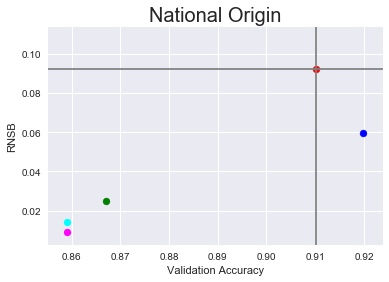

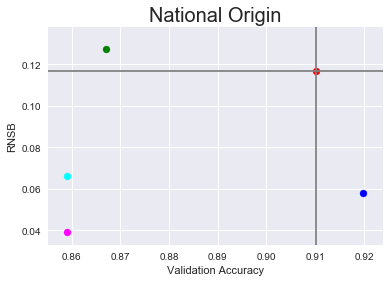

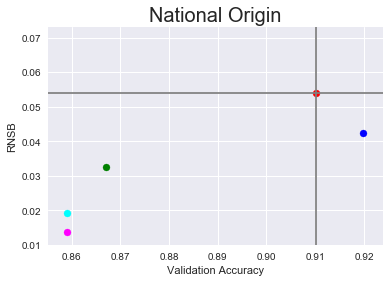

In [30]:
def annotate_data(labels, points, plt):

    for label, point in zip(labels, points):
        plt.annotate(label,xy=point,fontsize=15)
    

def plot_RNSB_scatter(og_lr, lr_debias, lr_minus5, lr_minus5_reg, lr_minus5_reg2):
    
#     rnsb_list = [lr.validation_fairness() for lr in lr_list]
#     validation_list = [lr.validation(lr.val[0],lr.val[1]) for lr in lr_list]
#     metric_a, metric_b, metric_c  = zip(*rnsb_list)
    
    
    
    (og_rnsb_a, og_rnsb_b, og_rnsb_c), og_acc = get_metrics(og_lr)
    (debias_rnsb_a, debias_rnsb_b, debias_rnsb_c), debias_acc = get_metrics(lr_debias)
    (minus5_rnsb_a, minus5_rnsb_b, minus5_rnsb_c), minus5_acc = get_metrics(lr_minus5)
    (minus5_reg_rnsb_a, minus5_reg_rnsb_b, minus5_reg_rnsb_c), minus5_reg_acc = get_metrics(lr_minus5_reg)
    (minus5_reg2_rnsb_a, minus5_reg2_rnsb_b, minus5_reg2_rnsb_c), minus5_reg2_acc = get_metrics(lr_minus5_reg2)

    %matplotlib inline
    plt.figure(figsize=(6,4))
    plt.title("National Origin",fontsize=20)
    plt.xlabel("Validation Accuracy")
    plt.ylabel("RNSB")
    plt.scatter(og_acc, og_rnsb_a, color="red")
    plt.scatter(debias_acc, debias_rnsb_a, color="green")
    plt.scatter(minus5_acc, minus5_rnsb_a, color="blue")
    plt.scatter(minus5_reg_acc, minus5_reg_rnsb_a, color="cyan")
    plt.scatter(minus5_reg2_acc, minus5_reg2_rnsb_a, color="magenta")
    plt.axes().axhline(y=og_rnsb_a, color="gray")
    plt.axes().axvline(x=og_acc, color="gray")
    plt.show()
    
    %matplotlib inline
    plt.figure(figsize=(6,4))
    plt.title("National Origin",fontsize=20)
    plt.xlabel("Validation Accuracy")
    plt.ylabel("RNSB")
    plt.scatter(og_acc, og_rnsb_b, color="red")
    plt.scatter(debias_acc, debias_rnsb_b, color="green")
    plt.scatter(minus5_acc, minus5_rnsb_b, color="blue")
    plt.scatter(minus5_reg_acc, minus5_reg_rnsb_b, color="cyan")
    plt.scatter(minus5_reg2_acc, minus5_reg2_rnsb_b, color="magenta")
    plt.axes().axhline(y=og_rnsb_b, color="gray")
    plt.axes().axvline(x=og_acc, color="gray")
    plt.show()
    
    %matplotlib inline
    plt.figure(figsize=(6,4))
    plt.title("National Origin",fontsize=20)
    plt.xlabel("Validation Accuracy")
    plt.ylabel("RNSB")
    plt.scatter(og_acc, og_rnsb_c, color="red")
    plt.scatter(debias_acc, debias_rnsb_c, color="green")
    plt.scatter(minus5_acc, minus5_rnsb_c, color="blue")
    plt.scatter(minus5_reg_acc, minus5_reg_rnsb_c, color="cyan")
    plt.scatter(minus5_reg2_acc, minus5_reg2_rnsb_c, color="magenta")
    plt.axes().axhline(y=og_rnsb_c, color="gray")
    plt.axes().axvline(x=og_acc, color="gray")
    plt.show()
    
    

plot_RNSB_scatter(og_lr, lr_debias, lr_minus5, lr_minus5_reg, lr_minus5_reg2)

## Plotting PCA

## Create fair regression terms

In [ ]:
N = np.zeros((len(nationalities),300))
for i,j in enumerate(nationalities):
    N[i,:] = embeddings[j.lower()]
R = np.zeros((len(religions),300))
for i,j in enumerate(religions):
    R[i,:] = embeddings[j.lower()]
G = np.zeros((len(gender),300))
for i,j in enumerate(gender):
    G[i,:] = embeddings[j.lower()]
regularizers = [N,R,G]

## train LR

In [ ]:
# for i in range(20):
#     # Create new train/test split, because using "new" training data each time
#     print("removing pca component: " + str(i))
#     train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
#         train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
        
#     lr = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers,reg_coeff=[0,0,0],lamb=0.01,num_iter=8000)
#     (RNSB,loss,validation_scores) = lr.fit(train_vectors,train_targets)
    
    

In [ ]:
lr = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers,reg_coeff=[0,0,0],lamb=0.01,num_iter=8000)
(RNSB,loss,validation_scores) = lr.fit(train_vectors,train_targets)
print("----------------------------------------------")
lr_debias = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers,reg_coeff=[.2,.2,.2],lamb=0.01,num_iter=8000)
(RNSB_debias,loss_debias,validation_scores_debias) = lr_debias.fit(train_vectors,train_targets)

## plot toxicity histogram for identity terms

In [ ]:
lr_debias.validation_fairness(),lr.validation_fairness()


In [ ]:
identity_toxicity = dict(identity_toxicity_table(gender,embeddings,lr))
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
plt.figure()
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.show()

In [ ]:
terms= []
for i in nationalities:
    terms.append("i love " + i + " food")

In [ ]:
identity_toxicity = dict(identity_toxicity_table(terms,embeddings,lr))
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
plt.figure()
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.show()

In [ ]:
identity_toxicity = dict(identity_toxicity_table(terms,embeddings,lr_debias))
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
plt.figure()
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.show()

In [ ]:
identity_toxicity = dict(identity_toxicity_table(gender,embeddings,lr_debias))
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
plt.figure()
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.show()

## Plot training curves

In [ ]:
plt.figure()
plt.plot(zip(*RNSB)[0],label="National Identity")
plt.plot(zip(*RNSB)[1],label="Religion")
plt.plot(zip(*RNSB)[2],label="Gender")

#maybe also do analysi with no regulaization


plt.title("Sentence Toxicity Classifcation, No Fair Regularization")
plt.xlabel("training steps")
plt.legend()

In [ ]:
np.argmax(zip(*RNSB_debias)[0])

In [ ]:
plt.figure()
plt.plot(zip(*RNSB_debias)[0][np.argmax(zip(*RNSB_debias)[0]):],label="National Identity")
plt.plot(zip(*RNSB_debias)[1][np.argmax(zip(*RNSB_debias)[1]):],label="Religion")
plt.plot(zip(*RNSB_debias)[2][np.argmax(zip(*RNSB_debias)[2]):],label="Gender")


plt.title("Sentence Toxicity Classifcation")
plt.xlabel("training steps")
plt.legend()

## test toxicity on gender equalized vs non equalized

In [ ]:
text_to_toxicity(lr,embeddings,'fuck'),text_to_toxicity(lr_debias,embeddings,'fuck')

In [ ]:
text_to_toxicity(lr,embeddings,'US'),text_to_toxicity(lr,embeddings,'mexico')

In [ ]:
text_to_toxicity(lr_debias,embeddings,'US'),text_to_toxicity(lr_debias,embeddings,'mexico')

In [ ]:
text_to_toxicity(lr,embeddings,'i am american'),text_to_toxicity(lr,embeddings,'i am mexican')

In [ ]:
text_to_toxicity(lr_debias,embeddings,'i am american'),text_to_toxicity(lr_debias,embeddings,"i am mexican")

In [ ]:
text_to_toxicity(lr,embeddings,'catholic'),text_to_toxicity(lr,embeddings,'jewish')

In [ ]:
text_to_toxicity(lr_debias,embeddings,'catholic'),text_to_toxicity(lr_debias,embeddings,'jewish')

In [ ]:
text_to_toxicity(lr,embeddings,'male'),text_to_toxicity(lr,embeddings,'female')

In [ ]:
text_to_toxicity(lr_debias,embeddings,'male'),text_to_toxicity(lr_debias,embeddings,'female')

In [ ]:
text_to_toxicity(lr,embeddings,'boy'),text_to_toxicity(lr,embeddings,'girl')

In [ ]:
text_to_toxicity(lr_debias,embeddings,'boy'),text_to_toxicity(lr_debias,embeddings,'girl')

In [ ]:
text_to_toxicity(lr_debias,embeddings,'dude'),text_to_toxicity(lr_debias,embeddings,'gal')

## create identity keyword toxicity histograms

In [ ]:
identity_toxicity_debias = dict(identity_toxicity_table(identities, embeddings_debiased,model_debias,add='/c/en/'))
identity_toxicity = dict(identity_toxicity_table(identities,embeddings,model))
keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
identity_toxicity_debias = {key: identity_toxicity_debias['/c/en/'+key] for key in keys_common }
identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=.8)
f.add_subplot(411)
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
f.add_subplot(412)
plt.title("Concept Net Debiased Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
f.add_subplot(413)
plt.title("Delta",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=-.06)
f.add_subplot(414)
plt.title('"Fair" Taget Distribution',fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

## model comparison with different methods

In [ ]:
identity_toxicity_debias = dict(identity_toxicity_table(nationalities, embeddings,model_debias_kernel))
identity_toxicity = dict(identity_toxicity_table(nationalities,embeddings,model))
# keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
# identity_toxicity_debias = {key: identity_toxicity_debias[key] for key in keys_common }
# identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=1.2)
f.add_subplot(411)
plt.title("GloVe Negative Sentiment Distribution",fontsize=35)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(412)
plt.title("GloVe Kernel Negative Sentiment Distribution",fontsize=35)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(413)
plt.title("Delta Between Word Embedding Distributions",fontsize=35)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=-.06)
f.add_subplot(414)
plt.title('Fair Uniform Taget Distribution',fontsize=35)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

In [ ]:
from pandas import DataFrame
import seaborn as sns
sns.set(font_scale=1.3)
%matplotlib inline
A = np.outer(identity_toxicity[1],identity_toxicity[1])

df = DataFrame(A, index=identity_toxicity[0], columns=identity_toxicity[0])

sns.heatmap(df, annot=False)

In [ ]:
A = np.outer(identity_toxicity_debias[1],identity_toxicity_debias[1])

df = DataFrame(A, index=identity_toxicity_debias[0], columns=identity_toxicity_debias[0])

sns.heatmap(df, annot=False)